MIE 5408 MACHINE LEARNING & ITS APPLICATION TO MECHANICAL ENGINEERING  
Paul Collette 25I000110

 
# **Final Project:**  
## **CNN based satellite image classification for Earth observation**  

**Create a new conda environment adapted to the code:**  
   
conda create -n cnn-env python=3.10 -y  
conda activate cnn-env  
pip install numpy==1.23.5  
pip install tensorflow==2.15.0  
pip install tensorflow-addons==0.22.0  
pip install tensorflow-datasets==4.9.2  
pip install tensorflow-hub==0.15.0  
pip install matplotlib==3.7.1  
pip install seaborn==0.12.2  
pip install scikit-learn==1.2.2  
    
**Or what to install and uninstall before running the code:**  
  
!pip uninstall -y jax jaxlib numpy   
!pip install numpy==1.23.5  
!pip install tensorflow==2.15.0 \  
  tensorflow-addons==0.22.0 \  
  tensorflow-datasets==4.9.2 \  
  tensorflow-hub==0.15.0 \  
  matplotlib==3.7.1 \  
  seaborn==0.12.2 \  
  scikit-learn==1.2.2  

## **Introduction**  

Satellite imagery provides a rich source of data for a variety of Earth observation tasks, from environmental monitoring to urban planning. However, efficiently analyzing and classifying these images requires robust computational methods. This notebook demonstrates a Convolutional Neural Network (CNN)-based approach to satellite image classification.  
  
Using a CNN, we aim to automatically classify satellite images into predefined categories.  

# **The program**

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_addons as tfa

<style>
  .justified {
    text-align: justify;
  }
</style>

<div class="justified">
  <p><strong>import os</strong>: Allows interaction with the operating system, such as file and directory handling.</p>

  <p><strong>import numpy as np</strong>: Imports NumPy for efficient numerical computations and array operations.</p>

  <p><strong>import matplotlib.pyplot as plt</strong>: Imports Matplotlib's plotting module to create static visualizations like charts or image displays.</p>

  <p><strong>import seaborn as sns</strong>: Imports Seaborn for enhanced statistical data visualization built on top of Matplotlib.</p>

  <p><strong>import tensorflow as tf</strong>: Loads TensorFlow, a deep learning library used to build and train neural networks.</p>

  <p><strong>import tensorflow_datasets as tfds</strong>: Imports TensorFlow Datasets, a collection of ready-to-use datasets for machine learning.</p>

  <p><strong>import tensorflow_hub as hub</strong>: Imports TensorFlow Hub to load and reuse pre-trained machine learning models.</p>

  <p><strong>import tensorflow_addons as tfa</strong>: Loads TensorFlow Addons, a library of extra tools and layers not included in the core TensorFlow package.</p>
</div>
  

In [3]:

# Load the 5% of the dataset
dataset, info = tfds.load("eurosat", split="train[:5%]", with_info=True, as_supervised=True)

# Load training, testing & validation sets, splitting by 3%, 1%, 1% ((60%, 20%, 20%) of 5%)
train_ds = tfds.load("eurosat", split="train[:3%]")
test_ds = tfds.load("eurosat", split="train[3%:4%]")
valid_ds = tfds.load("eurosat", split="train[4%:5%]")


Loads a small subset (5%) of the EuroSAT dataset using TensorFlow Datasets, including metadata (info) and labeled images (as_supervised=True). It then splits that 5% into training (3%), testing (1%), and validation (1%) sets based on index ranges within the dataset.  
  
I've decided to load only 5% of the dataset to speed up the training process.

c:\Users\colle\anaconda3\envs\cnn-env\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


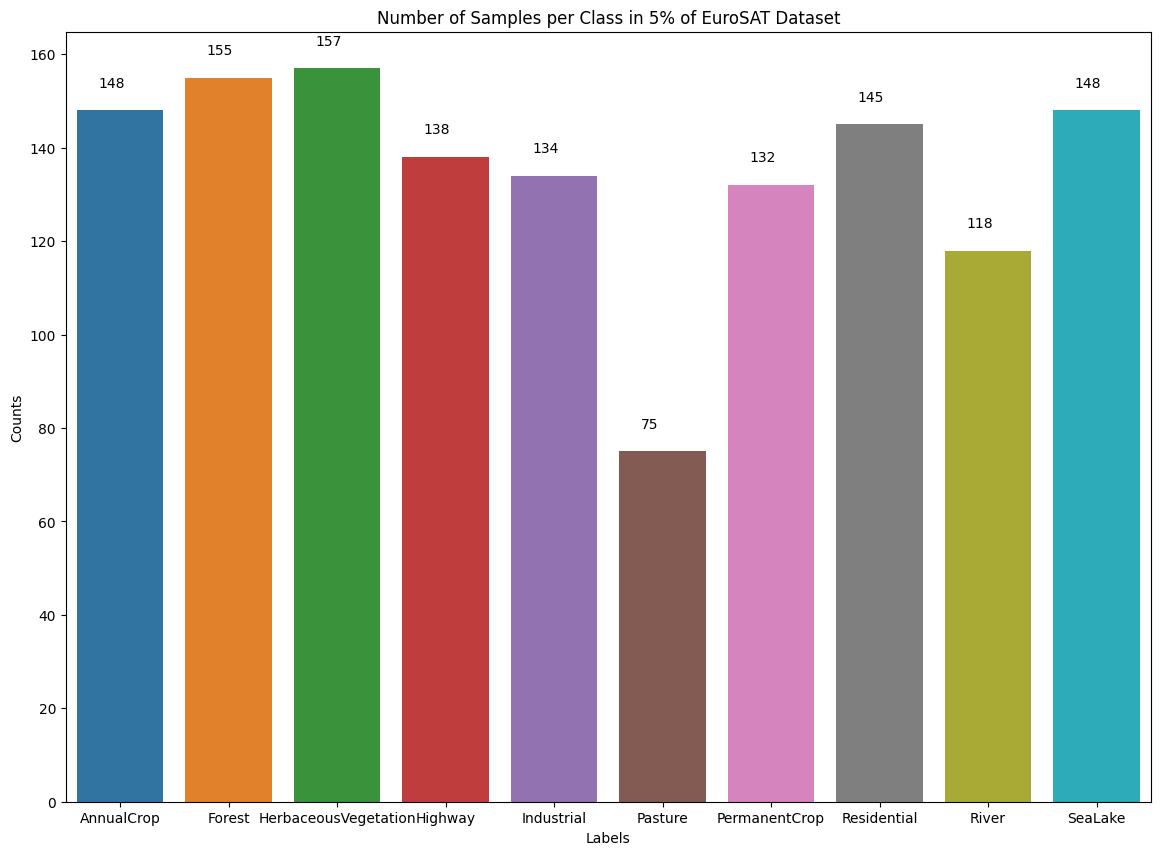

In [4]:

# list the labels
labels_list = [label.numpy() for (_, label) in dataset]  # Extract the labels from the dataset as numpy arrays
labels, counts = np.unique(labels_list, return_counts=True)  # np.unique() finds all the unique label values in labels_list

# Dataset infos
class_names = info.features["label"].names
num_classes = len(class_names)
num_examples = info.splits["train"].num_examples  # that tells you how many samples (data points) are in a specific split of a dataset.


# Plot
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
sns.barplot(x=[class_names[i] for i in labels], y=counts, ax=ax)
for i, x_ in enumerate(labels):
    ax.text(i - 0.2, counts[i] + 5, str(counts[i]))
plt.ylabel("Counts")
plt.xlabel("Labels")
plt.title("Number of Samples per Class in 5% of EuroSAT Dataset")
plt.show()

<style>
  .justified {
    text-align: justify;
  }
</style>

<div class="justified">
using <strong>plt.subplots()</strong> even when plotting just one graph gives you more power and flexibility than using plt.plot() or plt.figure() alone.  
  
<strong>y=counts</strong>: Number of samples for each class (from np.unique() earlier). <strong>ax=ax</strong>: Tells Seaborn to draw the plot on the ax object we created earlier (instead of creating a new one).  
  
<strong>x = i - 0.2</strong>: Places the label horizontally just a bit to the left of the center of the bar (-0.2 is a small shift for better alignment). <strong>y = counts[i] + 5</strong>: Places the label slightly above the top of the bar for visibility. <strong>str(counts[i])</strong>: Converts the count (integer) to a string to be displayed as text.
</div>

In [5]:
def prepare_for_training(ds, cache=True, batch_size=64, shuffle_buffer_size=1000):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.map(lambda d: (d["image"], tf.one_hot(d["label"], num_classes)))
    # shuffle the dataset
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # Repeat forever
    ds = ds.repeat()
    # split to batches
    ds = ds.batch(batch_size)
    # 'prefetch' lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds


**ds**: Your tf.data.Dataset (containing examples like images + labels).  
  
**cache**: True, cache the dataset in memory. Caching the dataset means it won't reload/reprocess from disk every epoch.  
  
 **batch_size**: Number of samples per training batch.  
  
**shuffle_buffer_size**: Controls how many items are randomly shuffled before each epoch.  
  
**ds = ds.map(lambda d: (d["image"], tf.one_hot(d["label"], num_classes)))**: Converts each sample d from: {"image": ..., "label": ...} to a tuple: (image, one-hot label). tf.one_hot() encodes labels as vectors (e.g., label 3 becomes [0, 0, 0, 1, 0, ...]).  
  
**ds = ds.shuffle(buffer_size=shuffle_buffer_size)**: Randomly shuffles the dataset, using a buffer of shuffle_buffer_sizeelements. Helps prevent overfitting and learning order-based patterns.  
  
**ds = ds.repeat()**: Makes the dataset repeat indefinitely. So it never "runs out" during training loops.  
  
**ds = ds.batch(batch_size)**: Groups elements into batches of batch_size.  
  
**ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)**: Prefetching allows the next batch to be prepared while the current one is being processed. Reduces bottlenecks and speeds up training. AUTOTUNE picks an optimal number of batches to prefetch based on your hardware.



In [6]:
batch_size = 64

# preprocess training & validation sets
train_ds = prepare_for_training(train_ds, batch_size=batch_size)
valid_ds = prepare_for_training(valid_ds, batch_size=batch_size)

The cell above is doing a quick sanity check on your dataset pipeline to make sure the shapes of the images and labels are correct after preprocessing and batching.  
  
**valid_ds.take(1)**: Takes just one batch from the validation dataset.

In [9]:
# take the first batch of the training set
batch = next(iter(train_ds))

In [23]:
def show_batch(batch):
    plt.figure(figsize=(16, 16))
    for n in range(min(32, batch_size)):
        ax = plt.subplot(batch_size//8, 8, n + 1)
        # show the image
        plt.imshow(batch[0][n]) 
        # and put the corresponding label as title upper to the image
        plt.title(class_names[tf.argmax(batch[1][n].numpy())])
        plt.axis('off')
    plt.savefig("sample-images.png")

**batch[0]**: This accesses the first element of the batch, which is a list or array of images.  
  
**batch[0][n]**: This accesses the nth image in the batch.  
  
**batch[1]**: This accesses the second element of the batch, which is a list or array of labels.  
  
**batch[1][n]**: This accesses the nth label in the batch. 
   
**tf.argmax**: This function returns the index of the maximum value in a tensor.  
  
**.numpy()**: This converts the tensor to a NumPy array.  

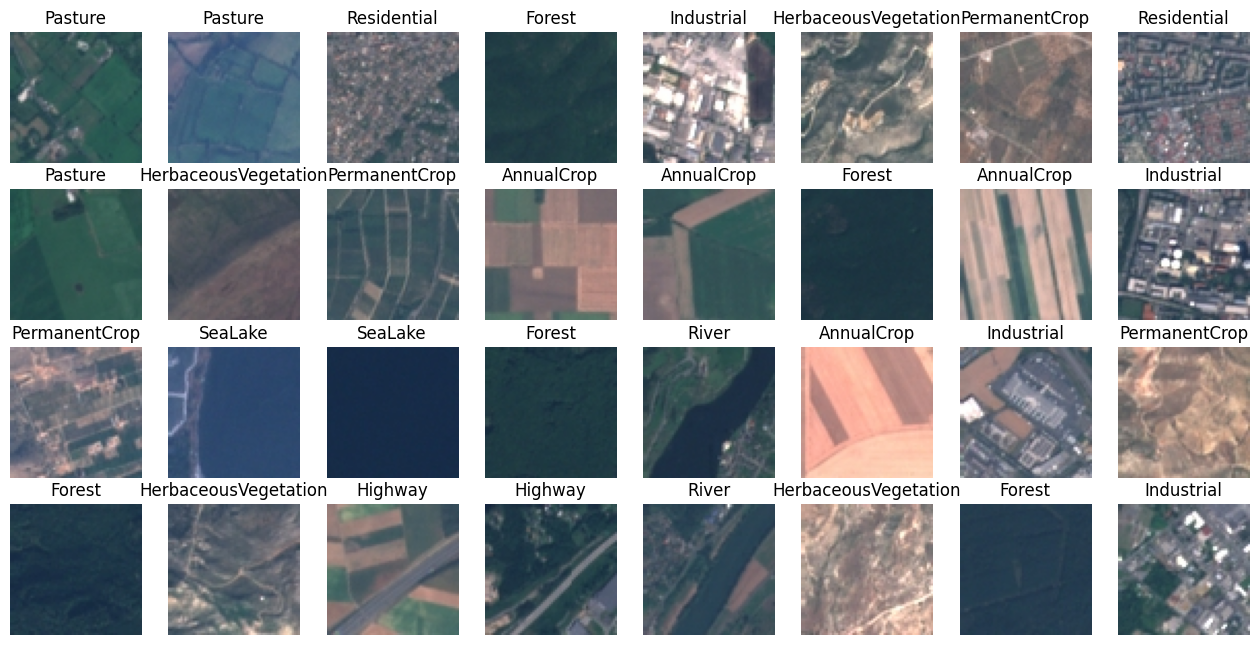

In [24]:

show_batch(batch)

In [36]:
model_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2"

# download & load the layer as a feature vector
keras_layer = hub.KerasLayer(model_url, output_shape=[1280], trainable=True)

**Model URL:** 
  
The URL https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2 points to a specific version of the EfficientNetV2 model.  
EfficientNetV2 is a family of models known for their efficiency and performance in image classification tasks.  
The feature_vector part of the URL indicates that this model is designed to output feature vectors, which are compact representations of the input images. 
     
**Downloading and Loading the Layer:**   
    
**hub.KerasLayer(model_url, output_shape=[1280], trainable=True)**:  
**hub.KerasLayer**: This function creates a Keras layer that wraps the pre-trained model.  
**model_url**: The URL of the pre-trained model.  
**output_shape=[1280]**: The shape of the output tensor. Here, it specifies that the output will be a vector of size 1280.     
  
**Purpose:**    
     
The purpose of this code is to create a Keras layer that uses a pre-trained EfficientNetV2 model to extract feature vectors from input images.  
These feature vectors can then be used as input to other layers in a neural network for tasks such as image classification, object detection, or other computer vision tasks.  


In [37]:
m = tf.keras.Sequential([
    keras_layer,
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

# build the model with input image shape as (64, 64, 3)
m.build([None, 64, 64, 3])
m.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy", tfa.metrics.F1Score(num_classes)]
)


The code creates a sequential model with two layers: a pre-trained feature extraction layer and a dense layer with a softmax activation function.
The model is built with an input shape of [None, 64, 64, 3], indicating that the input images are 64x64 pixels with 3 color channels.
The model is compiled with the categorical crossentropy loss function, the Adam optimizer, and two metrics: accuracy and F1 score.
This setup prepares the model for training on a multi-class classification task.


In [38]:
model_name = "satellite-classification"
model_path = os.path.join("results", model_name + ".h5")
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path, save_best_only=True, verbose=1)

The **tf.keras.callbacks.ModelCheckpoint** function creates a callback that saves the best model during training, with verbosity enabled to print messages when the model is saved.
This setup ensures that the best version of the model is saved during training, which can be useful for later evaluation or deployment.

In [ ]:
# set the training & validation steps since we're using .repeat() on our dataset
# number of training steps
n_training_steps = int(num_examples * 0.6) // batch_size
# number of validation steps
n_validation_steps = int(num_examples * 0.2) // batch_size

In [ ]:
# train the model
history = m.fit(
    train_ds,
    validation_data=valid_ds,
    steps_per_epoch=n_training_steps,
    validation_steps=n_validation_steps,
    verbose=1, #verbose is set to 1 to print progress during training 
    epochs=3,
    callbacks=[model_checkpoint]
)

 Epoch 1/3  
253/253 [==============================] - 1948s 8s/step - loss:   
0.0986 - accuracy: 0.9729 - f1_score: 0.9713 - val_loss: 0.3509 -   
val_accuracy: 0.9001 - val_f1_score: 0.8939   
 Epoch 2/3  
 253/253 [==============================] - ETA: 0s - loss: 0.0480 -   
accuracy: 0.9859 - f1_score: 0.9852  
 Epoch 2: val_loss did not improve from 0.35086  
 253/253 [==============================] - 1910s 8s/step - loss:   
0.0480 - accuracy: 0.9859 - f1_score: 0.9852 - val_loss: 0.4830 -   
val_accuracy: 0.8627 - val_f1_score: 0.8476  
 Epoch 3/3  
 253/253 [==============================] - ETA: 0s - loss: 0.0319 -   
accuracy: 0.9915 - f1_score: 0.9912  
 Epoch 3: val_loss did not improve from 0.35086  
 253/253 [==============================] - 1872s 7s/step - loss:   
0.0319 - accuracy: 0.9915 - f1_score: 0.9912 - val_loss: 0.3905 -   
val_accuracy: 0.9074 - val_f1_score: 0.8878  

In [ ]:
# load the best weights
m.load_weights(model_path) 

# number of testing steps
n_testing_steps = int(info.splits["train"].num_examples * 0.2)

# get all testing images as NumPy array
images = np.array([d["image"] for d in test_ds.take(n_testing_steps)])


**m.load_weights(model_path)**: This method loads the weights from the saved model file into the current model.   
   
**images = np.array([d["image"] for d in test_ds.take(n_testing_steps)])**: This line creates a NumPy array of all testing images.  
  
**test_ds.take(n_testing_steps)**: This takes n_testing_steps number of batches from the testing dataset.  
  
**[d["image"] for d in test_ds.take(n_testing_steps)]**: This is a list comprehension that extracts the "image" field from each batch in the testing dataset.  
  
**np.array(...)**: This converts the list of images into a NumPy array.


In [ ]:
# get all testing labels as NumPy array
labels = np.array([ d["label"] for d in test_ds.take(n_testing_steps) ])

In [ ]:
# feed the images to get predictions
predictions = m.predict(images)
# perform argmax to get class index
predictions = np.argmax(predictions, axis=1)

9/9 [==============================] - 9s 568ms/step


The **np.argmax(predictions, axis=1)** function is used to find the index of the highest probability for each image.  
**axis=1**: This parameter specifies that the argmax operation should be performed along the columns (classes) for each row (image).

In [ ]:
from sklearn.metrics import f1_score

accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(labels, predictions)
print("Accuracy:", accuracy.result().numpy())
print("F1 Score:", f1_score(labels, predictions, average="macro"))

Accuracy: 0.9037037
F1 Score: 0.9025575340284725


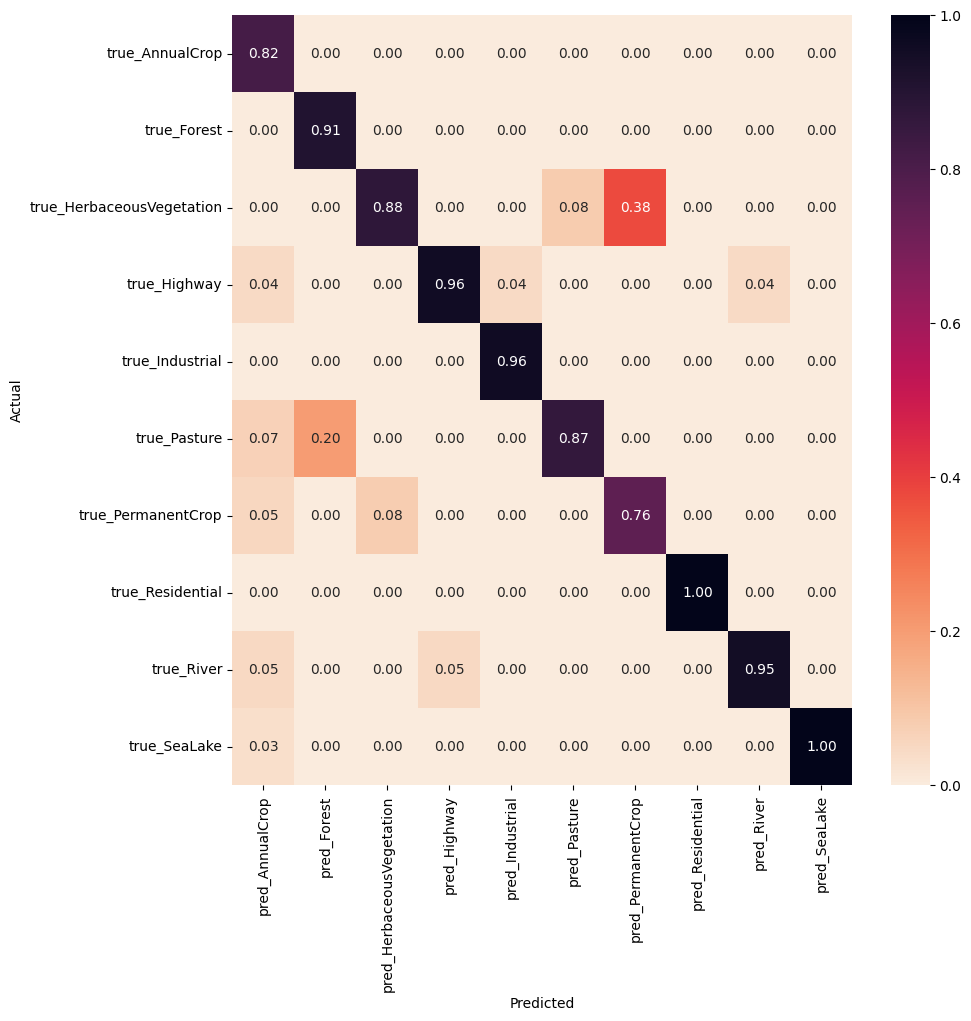

In [ ]:
# compute the confusion matrix
cmn = tf.math.confusion_matrix(labels, predictions).numpy()
# normalize the matrix to be in percentages
cmn = cmn.astype("float") / cmn.sum(axis=0)[:, np.newaxis]
# make a plot for the confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f',
    xticklabels=[f"pred_{c}" for c in class_names],
    yticklabels=[f"true_{c}" for c in class_names],
    # cmap="Blues"
    cmap="rocket_r")

plt.ylabel('Actual')
plt.xlabel('Predicted')
# plot the resulting confusion matrix
plt.savefig("confusion-matrix.png")
# plt.show()
plt.show()

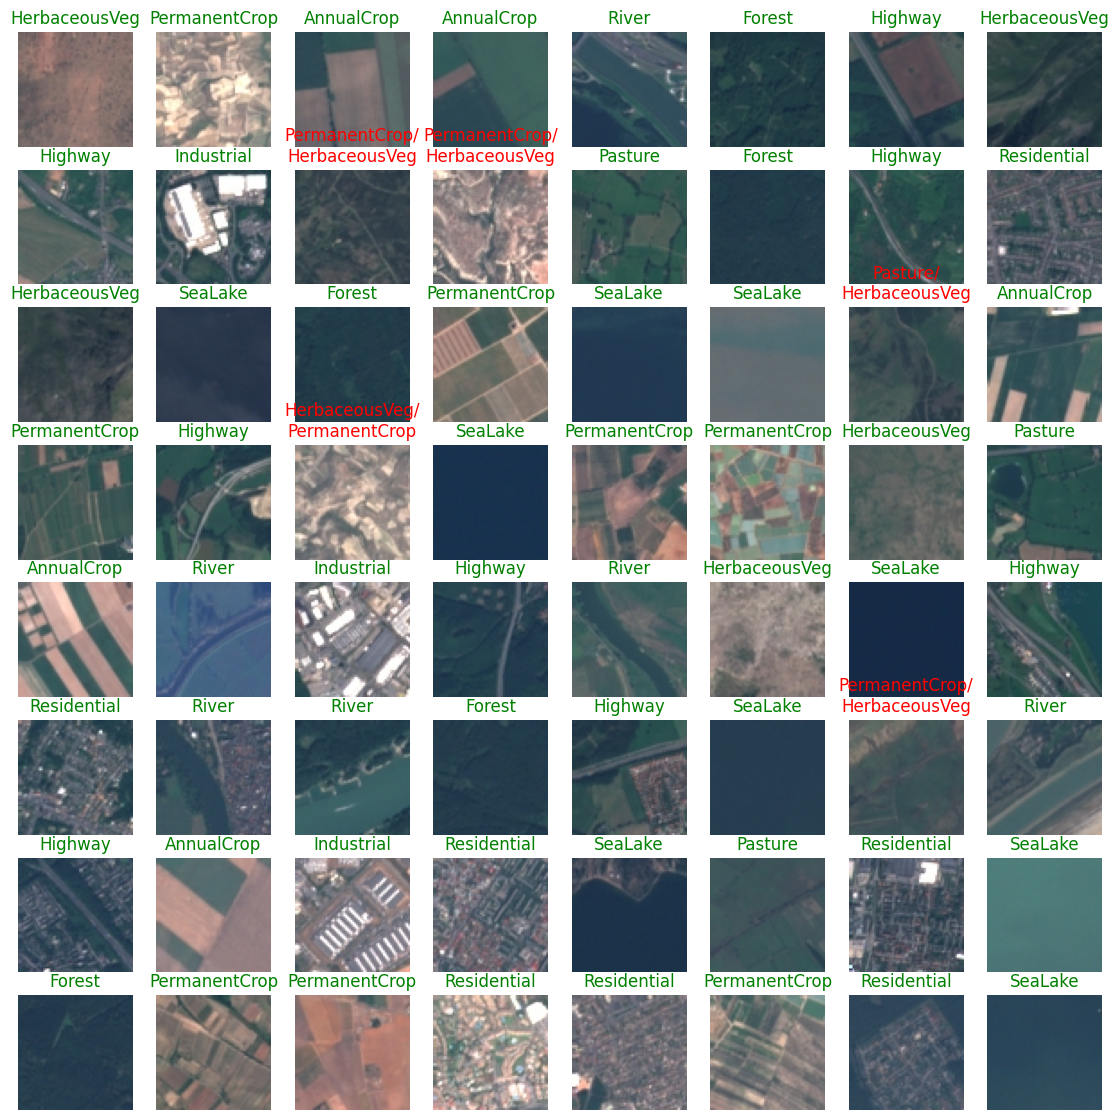

In [ ]:
def show_predicted_samples():
    plt.figure(figsize=(14, 14))
    for n in range(64):
        ax = plt.subplot(8, 8, n + 1)
        # show the image
        plt.imshow(images[n])
        # and put the corresponding label as title upper to the image
        if predictions[n] == labels[n]:
            # correct prediction
            ax.set_title(class_names[predictions[n]][:13], color="green")
        else:
            # wrong prediction
            ax.set_title(f"{class_names[predictions[n]][:13]}/\n{class_names[labels[n]][:13]}", color="red")
        plt.axis('off')
    plt.savefig("predicted-sample-images.png")

# showing a batch of images along with predictions labels
show_predicted_samples()